<a href="https://colab.research.google.com/github/nosadchiy/public/blob/main/LLMTimeSeries_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai==0.28

import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
# Statsmodels ARIMA/SARIMAX
import statsmodels.api as sm
import openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.75.0
    Uninstalling openai-1.75.0:
      Successfully uninstalled openai-1.75.0


In [2]:
########################################
# 1) Generate Daily Synthetic Demand
########################################

def generate_synthetic_ice_cream_demand(start_date="2024-01-01", end_date="2025-01-01"):
    """
    Generates synthetic daily ice cream demand data with:
    - A slight upward linear trend
    - Weekly seasonality (people tend to buy more on weekends)
    - Random noise
    """
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    n = len(date_range)

    # Trend component (slowly increasing)
    # e.g., base=100 at the start, grows ~ +0.5 units per day
    trend = 100 + 0.5 * np.arange(n)

    # Seasonality component (weekly: period=7)
    # We'll create a weekly pattern, for instance:
    # day 0 (Monday) = smaller, day 6 (Sunday) = peak
    day_of_week = date_range.dayofweek  # Monday=0, Sunday=6
    # Let’s create a simple cyclical pattern
    weekly_amp = 10.0  # amplitude for the weekly cycle
    seasonality = weekly_amp * np.sin(2 * np.pi * day_of_week / 7)

    # Random noise
    rng = np.random.default_rng(seed=42)
    noise = rng.normal(loc=0, scale=3.0, size=n)

    demand = trend + seasonality + noise
    # Round and ensure positivity
    demand = np.maximum(0, demand)
    demand_series = pd.DataFrame({
        "date": date_range,
        "demand": demand
    })
    return demand_series


########################################
# 2) Fetch Current Atlanta News
########################################

def get_atlanta_headlines(date_str):
    """
    Fetches news articles about Atlanta from the News API for a given date (date_str in 'YYYY-MM-DD' format).
    REPLACE 'YOUR_NEWS_API_KEY' with a valid API key from https://newsapi.org/.
    """
    API_KEY = "get a key from newsapi.org"
    url = "https://newsapi.org/v2/everything"

    params = {
        "q": "Atlanta",
        "from": date_str,
        "sortBy": "popularity",
        "language": "en",
        "apiKey": API_KEY
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code != 200 or "articles" not in data:
        print(f"Error fetching data: {data.get('message', 'Unknown error')}")
        return []

    articles = data["articles"]
    headlines = []
    for article in articles[:20]:
        title = article.get("title", "No Title")
        description = article.get("description", "")
        #url_link = article.get("url", "")
        #published = article.get("publishedAt", "")
        #headlines.append({"title": title, "description": description, "url": url_link, "published": published})
        headlines.append({"title": title, "description": description})

    return headlines


########################################
# 3) Call an LLM (OpenAI “4o-mini”) to Characterize News
########################################

def characterize_news_with_llm(headlines):
    # Takes a list of headlines, queries an LLM to generate a daily "impact score."
    # Returns a float in [-1, 1], indicating negative to positive impact on ice cream demand.
    # Suppose we combine headlines into a single prompt:
    combined_text = "\n".join([f"- {hd['title']}: {hd['description']}" for hd in headlines])

    prompt = f"""
    You are a model that estimates the impact of news on ice cream demand.
    Output only a single numeric score (float) between -1 and 1,
    where -1 means strongly negative impact,
    and +1 means strongly positive impact.
    Here are today's headlines about Atlanta:
    {combined_text}

    """

    openai.api_key = "Get a key from Open AI"


    response = openai.ChatCompletion.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {"role": "system", "content": "You are demand forecast assistant."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.0
    )


    # Suppose the response is just a string with the numeric score
    result_text = response.choices[0].message["content"]
    print(f"LLM response: {result_text}")

    try:
      impact_score = float(result_text)
    except ValueError:
      print("Invalid LLM text")
      impact_score = 0

    return impact_score


In [3]:
########################################
# 4) Bring It All Together
########################################

# Generate synthetic data
data = generate_synthetic_ice_cream_demand("2025-03-21", "2025-04-21")
data.set_index("date", inplace=True)
all_dates = data.index


################################
# Generate daily exogenous data for news impact
################################
impact_scores = []

for d in all_dates:
    # Format date for News API
    prevdate = d-timedelta(days=1)
    date_str = prevdate.strftime("%Y-%m-%d")
    headlines = get_atlanta_headlines(date_str)
    score = characterize_news_with_llm(headlines)
    impact_scores.append(score)




Error fetching data: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2025-03-20, but you have requested 2025-03-20. You may need to upgrade to a paid plan.
LLM response: Please provide the headlines about Atlanta so I can assess their impact on ice cream demand.
Invalid LLM text
LLM response: -0.2
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.1
LLM response: 0.2
LLM response: 0.1
LLM response: 0.2
LLM response: 0.2
LLM response: 0.2
LLM response: 0.2
LLM response: 0.2
LLM response: 0.2
LLM response: 0.0
LLM response: 0.0
LLM response: 0.0
LLM response: 0.0
LLM response: -0.3
LLM response: -0.3
LLM response: -0.2
LLM response: 0.0
LLM response: 0.2
LLM response: 0.2
LLM response: 0.3


In [6]:
################################
# Specify and fit baseline model
################################

# We'll split into train and "forecast" period
split_date = "2025-04-15"
train_data = data.loc[:split_date].copy()
test_data = data.loc[split_date:].copy()

# Fit a baseline SARIMAX (ARIMAX) with NO exogenous features first
# You can also use sm.tsa.arima.ARIMA if you don't plan on exogenous variables,
# but with exog we typically use SARIMAX.
# For simplicity, let’s set an order. Tuning p,d,q is recommended in practice.
order = (2, 1, 2)  # example
model_baseline = sm.tsa.SARIMAX(train_data["demand"], order=order, trend="t")
results_baseline = model_baseline.fit(disp=False)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Baseline ARIMA/SARIMAX model summary:

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                   26
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -69.899
Date:                Mon, 21 Apr 2025   AIC                            151.797
Time:                        14:24:49   BIC                            159.110
Sample:                    03-21-2025   HQIC                           153.826
                         - 04-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0248      0.019      1.279      0.201      -0.013       0.063
ar.L1          1.2504      0.068     18.404      0.000       1.117       1.384
ar.L2        

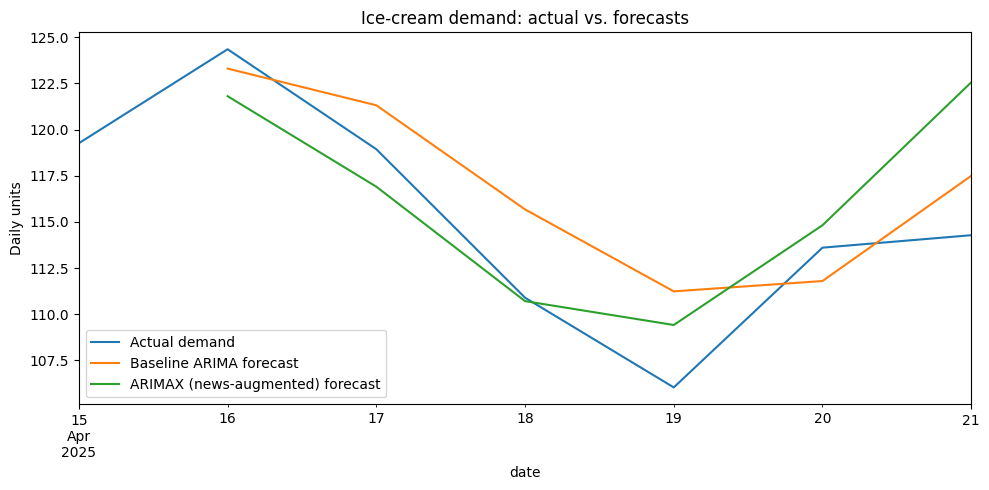

In [7]:
# Create a DataFrame for exogenous variable
exog_df = pd.DataFrame({"impact": impact_scores}, index=all_dates)

# Split exog into train/test
exog_train = exog_df.loc[:split_date].copy()
exog_test = exog_df.loc[split_date:].copy()

################################
# Fit a SARIMAX with the impact as exogenous
################################

model_exog = sm.tsa.SARIMAX(
    train_data["demand"],
    exog=exog_train,
    order=order,
    trend="t"
)
results_exog = model_exog.fit(disp=False)

print("Baseline ARIMA/SARIMAX model summary:\n")
print(results_baseline.summary())
print("\nARIMAX (with exogenous) model summary:\n")
print(results_exog.summary())

# Forecast using the exogenous model
# We'll forecast for the length of test_data
forecast_steps = len(test_data)

forecast_baseline = results_baseline.forecast(steps=forecast_steps)

forecast_exog = exog_test.copy()
forecast_results_exog = results_exog.forecast(steps=forecast_steps, exog=forecast_exog)

test_data["forecast_exog"] = forecast_results_exog
test_data["forecast_baseline"] = forecast_baseline

# Compare forecasts or plot
print(test_data[["demand", "forecast_exog", "forecast_baseline"]])
# e.g., Matplotlib quick plot:
import matplotlib.pyplot as plt
ax = test_data[["demand", "forecast_baseline", "forecast_exog"]].plot(
        figsize=(10, 5), title="Ice‑cream demand: actual vs. forecasts")
ax.set_ylabel("Daily units")
ax.legend(["Actual demand",
           "Baseline ARIMA forecast",
           "ARIMAX (news‑augmented) forecast"])
plt.tight_layout()
plt.show()
# The “forecast_exog” column is now your updated forecast that includes
# the effect of the daily news impact (as characterized by the LLM).
